# Regression-based neural network: Predicting Customer ADR

In this example, a regression-based neural network is implemented to predict customer ADR using the hotel cancellation datasets as provided by Antonio, Almeida and Nunes (2019). Attributions provided below.

#### Attributions

The below code uses the Sequential neural network model as built using the TensorFlow library, of which the original authors **(Copyright 2019 The TensorFlow Authors)** have made available under the Apache 2.0 license. Modifications have been made where appropriate for conducting analysis on the dataset specific to this example.

The data used in this example is sourced from [Antonio, Almeida and Nunes (2019)](https://www.sciencedirect.com/science/article/pii/S2352340918315191).

The below work and findings are not endorsed by the original authors in any way.

#### Apache 2.0 License

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Import Libraries

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
seed(1)
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import tensorflow
tensorflow.random.set_seed(1)
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2023-04-16 20:10:45.026246: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 20:10:45.082530: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 20:10:45.083289: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 20:10:46.087127: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data Preprocessing

In [3]:
train_df = pd.read_csv('H1.csv')
a=train_df.head()
b=train_df
b
b.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0,212,2017,August,35,31,2,8,2,1,...,No Deposit,143,NULL,0,Transient,89.75,0,0,Check-Out,2017-09-10
40056,0,169,2017,August,35,30,2,9,2,0,...,No Deposit,250,NULL,0,Transient-Party,202.27,0,1,Check-Out,2017-09-10
40057,0,204,2017,August,35,29,4,10,2,0,...,No Deposit,250,NULL,0,Transient,153.57,0,3,Check-Out,2017-09-12
40058,0,211,2017,August,35,31,4,10,2,0,...,No Deposit,40,NULL,0,Contract,112.80,0,1,Check-Out,2017-09-14


### Numerical variables

In [4]:
leadtime = train_df['LeadTime']
arrivaldateyear = train_df['ArrivalDateYear']
arrivaldateweekno = train_df['ArrivalDateWeekNumber']
arrivaldatedayofmonth = train_df['ArrivalDateDayOfMonth']
staysweekendnights = train_df['StaysInWeekendNights']
staysweeknights = train_df['StaysInWeekNights']
adults = train_df['Adults']
children = train_df['Children']
babies = train_df['Babies']
isrepeatedguest = train_df['IsRepeatedGuest'] 
previouscancellations = train_df['PreviousCancellations']
previousbookingsnotcanceled = train_df['PreviousBookingsNotCanceled']
bookingchanges = train_df['BookingChanges']
agent = train_df['Agent']
company = train_df['Company']
dayswaitinglist = train_df['DaysInWaitingList']
adr = train_df['ADR']
rcps = train_df['RequiredCarParkingSpaces']
totalsqr = train_df['TotalOfSpecialRequests']

In [5]:
y1 = np.array(adr)

### Categorical Variables

In [6]:
IsCanceled = train_df['IsCanceled']
arrivaldatemonth = train_df.ArrivalDateMonth.astype("category").cat.codes
arrivaldatemonthcat=pd.Series(arrivaldatemonth)
mealcat=train_df.Meal.astype("category").cat.codes
mealcat=pd.Series(mealcat)
countrycat=train_df.Country.astype("category").cat.codes
countrycat=pd.Series(countrycat)
marketsegmentcat=train_df.MarketSegment.astype("category").cat.codes
marketsegmentcat=pd.Series(marketsegmentcat)
distributionchannelcat=train_df.DistributionChannel.astype("category").cat.codes
distributionchannelcat=pd.Series(distributionchannelcat)
reservedroomtypecat=train_df.ReservedRoomType.astype("category").cat.codes
reservedroomtypecat=pd.Series(reservedroomtypecat)
assignedroomtypecat=train_df.AssignedRoomType.astype("category").cat.codes
assignedroomtypecat=pd.Series(assignedroomtypecat)
deposittypecat=train_df.DepositType.astype("category").cat.codes
deposittypecat=pd.Series(deposittypecat)
customertypecat=train_df.CustomerType.astype("category").cat.codes
customertypecat=pd.Series(customertypecat)
reservationstatuscat=train_df.ReservationStatus.astype("category").cat.codes
reservationstatuscat=pd.Series(reservationstatuscat)

In [7]:
x1 = np.column_stack((IsCanceled,countrycat,marketsegmentcat,deposittypecat,customertypecat,rcps,arrivaldateweekno))
x1 = sm.add_constant(x1, prepend=True)

## Training and Validation Data Partition

In [8]:
X_train, X_val, y_train, y_val = train_test_split(x1, y1)

In [9]:
#Variables
y_train=np.reshape(y_train, (-1,1))
y_val=np.reshape(y_val, (-1,1))

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

print(scaler_x.fit(X_train))
xtrain_scale=scaler_x.transform(X_train)
print(scaler_x.fit(X_val))
xval_scale=scaler_x.transform(X_val)

print(scaler_y.fit(y_train))
ytrain_scale=scaler_y.transform(y_train)
print(scaler_y.fit(y_val))
yval_scale=scaler_y.transform(y_val)

MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


In [10]:
ytrain_scale

array([[0.09988724],
       [0.0746141 ],
       [0.40122089],
       ...,
       [0.24763793],
       [0.33706598],
       [0.12127221]])

In [11]:
yval_scale

array([[0.10134897],
       [0.51727859],
       [0.12736657],
       ...,
       [0.12680352],
       [0.22521994],
       [0.14076246]])

In [12]:
xtrain_scale

array([[0.        , 1.        , 0.328     , ..., 0.66666667, 0.        ,
        0.23076923],
       [0.        , 0.        , 0.768     , ..., 0.66666667, 0.        ,
        0.19230769],
       [0.        , 0.        , 0.136     , ..., 0.66666667, 0.        ,
        0.51923077],
       ...,
       [0.        , 1.        , 0.768     , ..., 0.66666667, 0.        ,
        0.30769231],
       [0.        , 1.        , 0.368     , ..., 0.66666667, 0.        ,
        0.44230769],
       [0.        , 0.        , 0.768     , ..., 0.66666667, 0.        ,
        0.09615385]])

In [13]:
xval_scale

array([[0.        , 1.        , 0.7804878 , ..., 0.66666667, 0.        ,
        0.26923077],
       [0.        , 1.        , 0.7804878 , ..., 0.66666667, 0.        ,
        0.65384615],
       [0.        , 0.        , 0.37398374, ..., 0.        , 0.        ,
        0.28846154],
       ...,
       [0.        , 0.        , 0.37398374, ..., 0.66666667, 0.        ,
        0.88461538],
       [0.        , 0.        , 0.33333333, ..., 0.66666667, 0.        ,
        0.15384615],
       [0.        , 0.        , 0.37398374, ..., 1.        , 0.        ,
        0.38461538]])

# Neural Network Configuration

In [14]:
model = Sequential()
model.add(Dense(8, input_dim=8, kernel_initializer='normal', activation='elu'))
model.add(Dense(2670, activation='elu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 2670)              24030     
                                                                 
 dense_2 (Dense)             (None, 1)                 2671      
                                                                 
Total params: 26,773
Trainable params: 26,773
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history=model.fit(xtrain_scale, ytrain_scale, epochs=30, batch_size=150, verbose=1, validation_split=0.2)
predictions = model.predict(xval_scale)

Epoch 1/30
161/161 [==============================] - 2s 6ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0915 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.0857
Epoch 2/30
161/161 [==============================] - 1s 5ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0881 - val_loss: 0.0127 - val_mse: 0.0127 - val_mae: 0.0872
Epoch 3/30
161/161 [==============================] - 1s 4ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0879 - val_loss: 0.0129 - val_mse: 0.0129 - val_mae: 0.0848
Epoch 4/30
161/161 [==============================] - 1s 5ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0879 - val_loss: 0.0129 - val_mse: 0.0129 - val_mae: 0.0912
Epoch 5/30
161/161 [==============================] - 1s 8ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0881 - val_loss: 0.0127 - val_mse: 0.0127 - val_mae: 0.0880
Epoch 6/30
161/161 [==============================] - 1s 5ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0876 - val_loss: 0.0126 - val_mse: 0.0126 - val_mae: 0.0877
Epoch 7/30
161/1

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


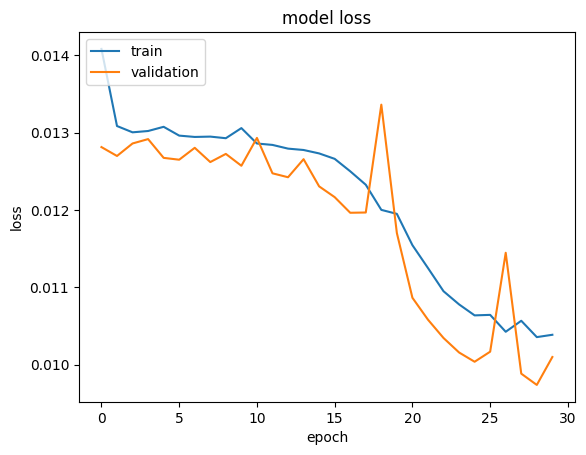

In [16]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Accuracy on validation set

In [17]:
predictions = scaler_y.inverse_transform(predictions)
predictions

array([[ 92.935555],
       [127.791084],
       [ 86.87735 ],
       ...,
       [ 87.19429 ],
       [ 71.56594 ],
       [ 99.56055 ]], dtype=float32)

In [18]:
mean_absolute_error(y_val, predictions)

40.674805370641245

In [19]:
mean_squared_error(y_val, predictions)
math.sqrt(mean_squared_error(y_val, predictions))

54.48860419666049

In [20]:
np.mean(y_val)

94.62558861707438

In [21]:
np.mean(predictions)

98.08243

# Test Data and Accuracy Readings

In [22]:
h2data = pd.read_csv('H2.csv')
a=h2data.head()
a

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-04-02


In [23]:
t_leadtime = h2data['LeadTime'] #1
t_arrivaldateyear = h2data['ArrivalDateYear']
t_arrivaldateweekno = h2data['ArrivalDateWeekNumber']
t_arrivaldatedayofmonth = h2data['ArrivalDateDayOfMonth']
t_staysweekendnights = h2data['StaysInWeekendNights'] #2
t_staysweeknights = h2data['StaysInWeekNights'] #3
t_adults = h2data['Adults'] #4
t_children = h2data['Children'] #5
t_babies = h2data['Babies'] #6
t_isrepeatedguest = h2data['IsRepeatedGuest'] #11
t_previouscancellations = h2data['PreviousCancellations'] #12
t_previousbookingsnotcanceled = h2data['PreviousBookingsNotCanceled'] #13
t_bookingchanges = h2data['BookingChanges'] #16
t_agent = h2data['Agent'] #18
t_company = h2data['Company'] #19
t_dayswaitinglist = h2data['DaysInWaitingList'] #20
t_adr = h2data['ADR'] #22
t_rcps = h2data['RequiredCarParkingSpaces'] #23
t_totalsqr = h2data['TotalOfSpecialRequests'] #24

In [24]:
# Categorical variables
t_IsCanceled = h2data['IsCanceled']
t_arrivaldatemonth = h2data.ArrivalDateMonth.astype("category").cat.codes
t_arrivaldatemonthcat = pd.Series(t_arrivaldatemonth)
t_mealcat=h2data.Meal.astype("category").cat.codes
t_mealcat=pd.Series(t_mealcat)
t_countrycat=h2data.Country.astype("category").cat.codes
t_countrycat=pd.Series(t_countrycat)
t_marketsegmentcat=h2data.MarketSegment.astype("category").cat.codes
t_marketsegmentcat=pd.Series(t_marketsegmentcat)
t_distributionchannelcat=h2data.DistributionChannel.astype("category").cat.codes
t_distributionchannelcat=pd.Series(t_distributionchannelcat)
t_reservedroomtypecat=h2data.ReservedRoomType.astype("category").cat.codes
t_reservedroomtypecat=pd.Series(t_reservedroomtypecat)
t_assignedroomtypecat=h2data.AssignedRoomType.astype("category").cat.codes
t_assignedroomtypecat=pd.Series(t_assignedroomtypecat)
t_deposittypecat=h2data.DepositType.astype("category").cat.codes
t_deposittypecat=pd.Series(t_deposittypecat)
t_customertypecat=h2data.CustomerType.astype("category").cat.codes
t_customertypecat=pd.Series(t_customertypecat)
t_reservationstatuscat=h2data.ReservationStatus.astype("category").cat.codes
t_reservationstatuscat=pd.Series(t_reservationstatuscat)

In [25]:
atest = np.column_stack((t_IsCanceled,t_countrycat,t_marketsegmentcat,t_deposittypecat,t_customertypecat,t_rcps,t_arrivaldateweekno))
atest = sm.add_constant(atest, prepend=True)
btest = t_adr
btest=btest.values

In [26]:
np.shape(atest)

(79330, 8)

In [27]:
scaler_atest = MinMaxScaler()
print(scaler_atest.fit(atest))
ascale=scaler_atest.transform(atest)

MinMaxScaler()


In [28]:
np.shape(ascale)

(79330, 8)

In [29]:
bpred = model.predict(ascale)
bpred

2480/2480 [==============================] - 3s 1ms/step


array([[0.2526181 ],
       [0.28530645],
       [0.28530645],
       ...,
       [0.23825729],
       [0.24180111],
       [0.23825729]], dtype=float32)

In [30]:
bpred = scaler_y.inverse_transform(bpred)

In [31]:
bpred

array([[107.67847 ],
       [121.61188 ],
       [121.61188 ],
       ...,
       [101.55717 ],
       [103.067726],
       [101.55717 ]], dtype=float32)

In [32]:
btest

array([  0.  ,  76.5 ,  68.  , ..., 157.71, 104.4 , 151.2 ])

In [33]:
np.shape(btest)

(79330,)

In [34]:
np.shape(bpred)

(79330, 1)

In [35]:
bpred=np.reshape(bpred, (79330,)) 

In [36]:
np.shape(bpred)

(79330,)

## Accuracy on test set

In [37]:
mean_absolute_error(btest, bpred)

29.54354074298041

In [38]:
mean_squared_error(btest, bpred)

1996.8632772215315

In [39]:
math.sqrt(mean_squared_error(btest, bpred))

44.68627616194408

In [40]:
np.mean(btest)

105.30446539770578

In [41]:
np.max(btest)

5400.0

In [42]:
np.quantile(btest, 0.8)

132.3

In [43]:
np.quantile(btest, 0.9)

156.3030000000002

In [44]:
np.quantile(btest, 0.95)

175.5

In [45]:
np.quantile(btest, 0.99)

228.0

In [46]:
np.mean(bpred)

90.00989